# Run the MSAEXP pipeline steps for an example dataset from GO-2561 (UNCOVER)

*Pipeline steps*

1. Run the preprocessing pipline through extracting 2D cutouts
1. Combine and rectify the cutouts to a final stack
1. Extract 1D spectrum
1. (fit redshift, line fluxes, etc. (``s2_specAnalysis.ipynb``)

In [1]:
# CRDS variables
import os
if 'CRDS_PATH' not in os.environ is None:
    os.environ['CRDS_PATH'] = f'{os.getcwd()}/crds_cache'

    if not os.path.exists(os.environ['CRDS_PATH']):
        os.makedirs(os.environ['CRDS_PATH'])

os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
os.environ['CRDS_CONTEXT'] = 'jwst_1312.pmap'

In [3]:
import os
import glob
import yaml
import warnings
import time

import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
import jwst.datamodels
import jwst

import mastquery.jwst

import msaexp
from msaexp import pipeline
import msaexp.slit_combine
from msaexp import utils as msautils
from msaexp import msa

print(f'jwst version = {jwst.__version__}')
print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')

plt.rcParams['scatter.marker'] = '.'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['grid.linestyle'] = ':'

jwst version = 1.16.0
grizli version = 1.12.14
msaexp version = 0.9.9.dev21+gae09813


In [65]:
prog = 2561
progstr = 'jw02561'
rootdir = '/Users/xwang/data/NIRSpec/go2561_uncover_westlake/DR250705'
os.chdir(rootdir)

outroot = 'uncover-v3'

In [5]:
files = glob.glob(f'jw*rate.fits')

print(files)

['jw02561002003_07101_00001_nrs1_rate.fits', 'jw02561002003_03101_00007_nrs1_rate.fits', 'jw02561002003_03101_00006_nrs1_rate.fits', 'jw02561002003_03101_00003_nrs1_rate.fits', 'jw02561002003_07101_00005_nrs1_rate.fits', 'jw02561002003_07101_00002_nrs1_rate.fits', 'jw02561002003_03101_00004_nrs1_rate.fits', 'jw02561002003_03101_00005_nrs1_rate.fits', 'jw02561002003_07101_00003_nrs1_rate.fits', 'jw02561002003_07101_00004_nrs1_rate.fits', 'jw02561002003_03101_00002_nrs1_rate.fits', 'jw02561002003_05101_00005_nrs1_rate.fits', 'jw02561002003_05101_00002_nrs1_rate.fits', 'jw02561002003_05101_00003_nrs1_rate.fits', 'jw02561002003_05101_00004_nrs1_rate.fits', 'jw02561002003_05101_00006_nrs1_rate.fits', 'jw02561002003_05101_00001_nrs1_rate.fits']


In [6]:
# Unset DQ=4 pixels to avoid running ``snowblind`` for now
for file in files:
    with pyfits.open(file, mode='update') as im:
        im['DQ'].data -= (im['DQ'].data & 4)
        im.flush()

In [7]:
GRATING_LIMITS = {'prism': [0.58, 5.33, 0.01], 
                  'g140m': [0.68, 1.9, 0.00063], 
                  'g235m': [1.66, 3.17, 0.00106], 
                  'g395m': [2.83, 5.24, 0.00179],
                  'g140h': [0.68, 1.9, 0.000238], 
                  'g235h': [1.66, 3.17, 0.000396], 
                  'g395h': [2.83, 5.24, 0.000666]
                  }

### test: plot msa metal file
adapted from `msa.MSAMetafile()`

In [9]:

msafn = 'jw02561002003_01_msa.fits'

cat = utils.GTable(fits.getdata(msafn,3))

# A2744-QSO1
ra0  = 3.5798408
dec0 = -30.4015681

targets = utils.GTable()
targets['id'] = np.array(['A2744-QSO1'])
targets['ra'] = np.array([3.5798408])
targets['dec'] = np.array([-30.4015681])

idx, dr = cat.match_to_catalog_sky(targets)
indices = []
for i, n in enumerate(idx):
    if dr[i].value > 1.:
        print(targets['id'][i], ' not matched...')
        continue
    else:
        indices.append(i)

obj = utils.GTable()
obj['id'] = cat['source_id'][idx][indices]
obj['ra'] = targets['ra'][indices]
obj['dec'] = targets['dec'][indices]
obj['idx'] = idx[indices]
obj['dr'] = dr[indices]  # .to(u.mas)
obj['dr'].format = '0.2f'
obj['name'] = targets['id'][indices]

print(obj)


  id      ra        dec     idx   dr      name   
         deg        deg         arcsec           
----- --------- ----------- --- ------ ----------
13123 3.5798408 -30.4015681 102   0.04 A2744-QSO1


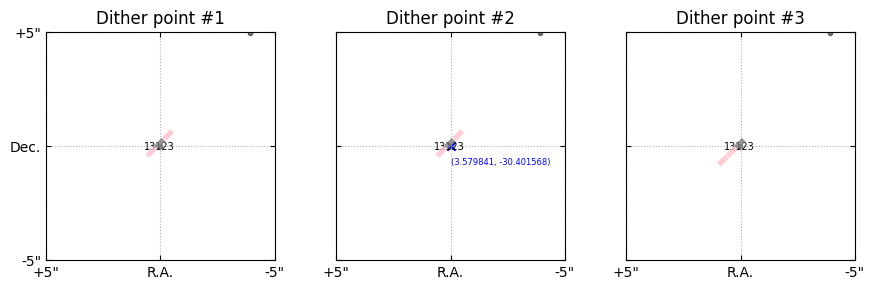

In [14]:
d_ra = 0.001
d_dec = 0.001

meta = msa.MSAMetafile(msafn)

fig, axes = plt.subplots(1,3,figsize=(9,2.6), sharex=True, sharey=True)
cosd = np.cos(np.median(meta.src_table['dec'])/180*np.pi)

# Show offset slitlets from three dithered exposures
for i in [0,1,2]:
    ax = axes[i]
    ax.scatter(meta.src_table['ra'], meta.src_table['dec'],
               marker='.', color='k', alpha=0.5)
    slits = meta.regions_from_metafile(dither_point_index=i+1,
                                       as_string=False, with_bars=True)
    for s in slits:
        if s.meta['is_source']:
            if s.meta['source_id'] in [obj['id']]:
                ax.text(s.meta['ra'] - 0.8/3600, s.meta['dec'],
                        s.meta['source_id'],
                        fontsize=7, ha='left', va='center')
            fc = '0.5'
        else:
            fc = 'pink'

        for patch in s.get_patch(fc=fc, ec='None', alpha=0.8, zorder=100):
            ax.add_patch(patch)

    ax.set_aspect(1./cosd)
    # ax.set_xlim(3.5936537138517317, 3.588363444812261)
    # ax.set_ylim(-30.39750646306242, -30.394291511397544)
    ax.set_xlim(ra0-d_ra, ra0+d_ra)
    ax.set_ylim(dec0-d_dec, dec0+d_dec)

    ax.grid()
    ax.set_title(f'Dither point #{i+1}')

x0 = np.mean(ax.get_xlim())
ax.set_xticks(np.array([-5, 0, 5])/3600./cosd + x0)
ax.set_xticklabels(['+5"', 'R.A.', '-5"'])

y0 = np.mean(ax.get_ylim())
ax.set_yticks(np.array([-5, 0, 5])/3600. + y0)
axes[0].set_yticklabels(['-5"', 'Dec.', '+5"'])
axes[1].scatter(x0, y0, marker='x', c='b')
axes[1].text(0.5, 0.45, f'({x0:.6f}, {y0:.6f})', ha='left', va='top',
             transform=axes[1].transAxes, fontsize=6,
             color='b')

fig.tight_layout(pad=0.5)


# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

## Preprocessing pipeline

1. Apply 1/f correction and identify "snowballs" on the `rate.fits` files
1. Remove "bias" (i.e., simple median) of each exposure
1. Rescale RNOISE array based on empty parts of the exposure
1. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
    - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
    - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
    - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
    - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
    - [BarShadowStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.barshadow.BarShadowStep.html#jwst.barshadow.BarShadowStep) : Bar Shadow
        - See also [MSAEXP PR#66](https://github.com/gbrammer/msaexp/pull/66)
    - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
    - Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
1. Parse slit metadata
1. Save slit cutout `SlitModel` files of the last pipeline step performed (`phot` = `PhotomStep`)

## Note! 

When the ``source_ids`` list is specified, the pipeline is only run for those sources in the MSA plan and will be much faster.  Set ``source_ids=None`` to extract *everything*.

In [59]:
os.path.exists(f'{mode}.slits.yaml')

True

In [61]:
redo_COMPLETED = True
source_ids = [13123,17467]
# Only include the example sources. or can you `None` to reduce data for all targets in the mask

for file in files:
    mode = '-'.join(file.split('_')[:4])
    im=pyfits.open(file)
    if  "MSAMETFL" in im[0].header:
        if (not os.path.exists(f'{mode}.slits.yaml')) or redo_COMPLETED:
            pipe = pipeline.NirspecPipeline(mode=mode, files=[file])
            pipe = pipeline.NirspecPipeline(mode=mode,
                                            files=[file],
                                            source_ids=source_ids,
                                            positive_ids=True # Ignore background slits
                                        ) 
            
            pipe.full_pipeline(run_extractions=False,
                            initialize_bkg=False,
                            load_saved=None,
                            scale_rnoise=True)
        else:
            print(f'Skip preprocessing: {mode}')
            continue
    else:
        print('The fits have not MSAMETFL in the header')
        continue

# (2025-07-05 04:08:28.684)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:08:28.851)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-05 04:08:29.237)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:08:29.239)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00001-nrs1', 'files': ['jw02561002003_07101_00001_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 24, 'mask_bit': 1024, 'instruments': ['NIRSPEC'], 'max_fraction': 0.3, 'unset4': 

2025-07-05 12:08:31,668 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:08:31,715 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:08:31,760 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:08:31,883 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:08:32.581)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-05 04:08:33.393)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-05 04:08:34.305)
msaexp.jwst.PathLossStep: jw02561002003_07101_00001_nrs1_rate.fits
# (2025-07-05 04:08:34.650)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00001_nrs1_rate.fits


2025-07-05 12:08:35,381 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:08:35.020)
msaexp.jwst.PhotomStep: jw02561002003_07101_00001_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00001-nrs1
# Get slitlet data from jw02561002003-07101-00001-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:08:35.341)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00001-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:08:35,558 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00001_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:08:35.721)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00007-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00007_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00007-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:08:35.850)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00007-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-05 04:08:36.226)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00007-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:08:36.228)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00007-nrs1', 'files': ['jw02561002003_03101_00007_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:08:38,407 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:08:38,462 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:08:38,501 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:08:38,605 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:08:39.374)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-05 04:08:40.098)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-05 04:08:40.844)
msaexp.jwst.PathLossStep: jw02561002003_03101_00007_nrs1_rate.fits
# (2025-07-05 04:08:41.162)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00007_nrs1_rate.fits


2025-07-05 12:08:41,872 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:08:41.517)
msaexp.jwst.PhotomStep: jw02561002003_03101_00007_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00007-nrs1
# Get slitlet data from jw02561002003-03101-00007-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:08:41.833)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00007-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:08:42,053 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00007_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:08:42.217)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00006_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:08:42.383)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-05 04:08:42.768)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:08:42.769)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00006-nrs1', 'files': ['jw02561002003_03101_00006_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:08:44,932 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:08:44,983 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:08:45,043 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:08:45,186 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:08:45.811)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-05 04:08:46.534)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-05 04:08:47.266)
msaexp.jwst.PathLossStep: jw02561002003_03101_00006_nrs1_rate.fits
# (2025-07-05 04:08:47.574)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00006_nrs1_rate.fits


2025-07-05 12:08:48,282 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:08:47.934)
msaexp.jwst.PhotomStep: jw02561002003_03101_00006_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00006-nrs1
# Get slitlet data from jw02561002003-03101-00006-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:08:48.244)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00006-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:08:48,459 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00006_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:08:48.624)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:08:48.756)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-05 04:08:49.142)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:08:49.144)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00003-nrs1', 'files': ['jw02561002003_03101_00003_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:08:51,290 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:08:51,340 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:08:51,394 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:08:51,489 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:08:52.252)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-05 04:08:52.968)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-05 04:08:53.709)
msaexp.jwst.PathLossStep: jw02561002003_03101_00003_nrs1_rate.fits
# (2025-07-05 04:08:54.018)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00003_nrs1_rate.fits


2025-07-05 12:08:54,712 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:08:54.366)
msaexp.jwst.PhotomStep: jw02561002003_03101_00003_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00003-nrs1
# Get slitlet data from jw02561002003-03101-00003-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:08:54.674)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00003-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:08:54,895 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00003_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:08:55.063)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00005_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:08:55.192)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-05 04:08:55.573)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:08:55.574)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00005-nrs1', 'files': ['jw02561002003_07101_00005_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:08:57,727 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:08:57,771 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:08:57,802 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:08:57,907 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:08:58.548)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-05 04:08:59.323)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-05 04:09:00.071)
msaexp.jwst.PathLossStep: jw02561002003_07101_00005_nrs1_rate.fits
# (2025-07-05 04:09:00.379)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00005_nrs1_rate.fits


2025-07-05 12:09:01,089 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:00.735)
msaexp.jwst.PhotomStep: jw02561002003_07101_00005_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00005-nrs1
# Get slitlet data from jw02561002003-07101-00005-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:01.050)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00005-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:01,268 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00005_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:01.437)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:01.569)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-05 04:09:01.953)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:01.954)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00002-nrs1', 'files': ['jw02561002003_07101_00002_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:04,124 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:04,162 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:04,217 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:04,318 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:04.935)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-05 04:09:05.610)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-05 04:09:06.341)
msaexp.jwst.PathLossStep: jw02561002003_07101_00002_nrs1_rate.fits
# (2025-07-05 04:09:06.643)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00002_nrs1_rate.fits


2025-07-05 12:09:07,341 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:06.991)
msaexp.jwst.PhotomStep: jw02561002003_07101_00002_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00002-nrs1
# Get slitlet data from jw02561002003-07101-00002-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:07.303)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00002-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:07,519 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00002_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:07.682)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00004_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:07.810)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-05 04:09:08.194)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:08.196)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00004-nrs1', 'files': ['jw02561002003_03101_00004_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:10,419 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:10,479 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:10,528 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:10,711 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:11.467)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-05 04:09:12.185)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-05 04:09:12.925)
msaexp.jwst.PathLossStep: jw02561002003_03101_00004_nrs1_rate.fits
# (2025-07-05 04:09:13.261)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00004_nrs1_rate.fits


2025-07-05 12:09:13,987 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:13.629)
msaexp.jwst.PhotomStep: jw02561002003_03101_00004_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00004-nrs1
# Get slitlet data from jw02561002003-03101-00004-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:13.947)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00004-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:14,170 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00004_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:14.341)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00005_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:14.473)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-05 04:09:14.856)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:14.857)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00005-nrs1', 'files': ['jw02561002003_03101_00005_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:17,013 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:17,061 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:17,095 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:17,208 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:17.960)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-05 04:09:18.715)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-05 04:09:19.491)
msaexp.jwst.PathLossStep: jw02561002003_03101_00005_nrs1_rate.fits
# (2025-07-05 04:09:19.799)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00005_nrs1_rate.fits


2025-07-05 12:09:20,506 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:20.155)
msaexp.jwst.PhotomStep: jw02561002003_03101_00005_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00005-nrs1
# Get slitlet data from jw02561002003-03101-00005-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:20.468)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00005-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:20,683 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00005_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:20.847)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:20.977)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-05 04:09:21.359)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:21.360)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00003-nrs1', 'files': ['jw02561002003_07101_00003_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:23,520 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:23,570 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:23,611 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:23,726 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:24.401)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-05 04:09:25.081)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-05 04:09:25.825)
msaexp.jwst.PathLossStep: jw02561002003_07101_00003_nrs1_rate.fits
# (2025-07-05 04:09:26.133)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00003_nrs1_rate.fits


2025-07-05 12:09:26,833 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:26.483)
msaexp.jwst.PhotomStep: jw02561002003_07101_00003_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00003-nrs1
# Get slitlet data from jw02561002003-07101-00003-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:26.794)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00003-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:27,011 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00003_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:27.175)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00004_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-07101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:27.304)
msaexp.NirspecPipeline: Initialize jw02561002003-07101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-05 04:09:27.682)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-07101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:27.683)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-07101-00004-nrs1', 'files': ['jw02561002003_07101_00004_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:29,839 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:29,896 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:29,959 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:30,073 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:30.838)
msaexp.jwst.Extract2dStep: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-05 04:09:31.602)
msaexp.jwst.FlatFieldStep: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-05 04:09:32.362)
msaexp.jwst.PathLossStep: jw02561002003_07101_00004_nrs1_rate.fits
# (2025-07-05 04:09:32.675)
msaexp.jwst.BarShadowStep: jw02561002003_07101_00004_nrs1_rate.fits


2025-07-05 12:09:33,403 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:33.043)
msaexp.jwst.PhotomStep: jw02561002003_07101_00004_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-07101-00004-nrs1
# Get slitlet data from jw02561002003-07101-00004-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:33.365)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-07101-00004-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:33,582 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_07101_00004_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:33.746)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-03101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:33.876)
msaexp.NirspecPipeline: Initialize jw02561002003-03101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-05 04:09:34.264)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-03101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:34.266)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-03101-00002-nrs1', 'files': ['jw02561002003_03101_00002_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:36,513 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:36,561 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:36,617 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:36,740 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:37.400)
msaexp.jwst.Extract2dStep: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-05 04:09:38.149)
msaexp.jwst.FlatFieldStep: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-05 04:09:38.888)
msaexp.jwst.PathLossStep: jw02561002003_03101_00002_nrs1_rate.fits
# (2025-07-05 04:09:39.212)
msaexp.jwst.BarShadowStep: jw02561002003_03101_00002_nrs1_rate.fits


2025-07-05 12:09:39,937 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:39.575)
msaexp.jwst.PhotomStep: jw02561002003_03101_00002_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-03101-00002-nrs1
# Get slitlet data from jw02561002003-03101-00002-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:39.898)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-03101-00002-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:40,115 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_03101_00002_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:40.281)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00005_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:40.412)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00005-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-05 04:09:40.792)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00005-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:40.793)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00005-nrs1', 'files': ['jw02561002003_05101_00005_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:42,964 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:43,007 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:43,041 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:43,140 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:43.916)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-05 04:09:44.631)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-05 04:09:45.363)
msaexp.jwst.PathLossStep: jw02561002003_05101_00005_nrs1_rate.fits
# (2025-07-05 04:09:45.672)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00005_nrs1_rate.fits


2025-07-05 12:09:46,384 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:46.028)
msaexp.jwst.PhotomStep: jw02561002003_05101_00005_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00005-nrs1
# Get slitlet data from jw02561002003-05101-00005-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:46.345)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00005-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:46,563 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00005_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:46.726)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:46.857)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00002-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-05 04:09:47.241)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00002-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:47.242)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00002-nrs1', 'files': ['jw02561002003_05101_00002_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:49,403 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:49,458 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:49,511 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:49,604 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:50.271)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-05 04:09:50.953)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-05 04:09:51.691)
msaexp.jwst.PathLossStep: jw02561002003_05101_00002_nrs1_rate.fits
# (2025-07-05 04:09:51.996)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00002_nrs1_rate.fits


2025-07-05 12:09:52,709 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:52.357)
msaexp.jwst.PhotomStep: jw02561002003_05101_00002_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00002-nrs1
# Get slitlet data from jw02561002003-05101-00002-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:52.671)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00002-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:52,888 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00002_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:53.052)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:53.183)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00003-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-05 04:09:53.557)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00003-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:53.558)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00003-nrs1', 'files': ['jw02561002003_05101_00003_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:09:55,724 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:09:55,787 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:09:55,849 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:09:55,988 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:09:56.656)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-05 04:09:57.342)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-05 04:09:58.096)
msaexp.jwst.PathLossStep: jw02561002003_05101_00003_nrs1_rate.fits
# (2025-07-05 04:09:58.412)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00003_nrs1_rate.fits


2025-07-05 12:09:59,127 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:09:58.766)
msaexp.jwst.PhotomStep: jw02561002003_05101_00003_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00003-nrs1
# Get slitlet data from jw02561002003-05101-00003-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:09:59.088)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00003-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:09:59,306 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00003_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:09:59.471)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00004_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:09:59.603)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00004-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-05 04:09:59.989)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00004-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:09:59.990)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00004-nrs1', 'files': ['jw02561002003_05101_00004_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:10:02,166 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:10:02,232 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:10:02,284 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:10:02,399 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:10:03.287)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-05 04:10:04.155)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-05 04:10:04.897)
msaexp.jwst.PathLossStep: jw02561002003_05101_00004_nrs1_rate.fits
# (2025-07-05 04:10:05.212)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00004_nrs1_rate.fits


2025-07-05 12:10:05,924 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:10:05.565)
msaexp.jwst.PhotomStep: jw02561002003_05101_00004_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00004-nrs1
# Get slitlet data from jw02561002003-05101-00004-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:10:05.882)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00004-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:10:06,109 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00004_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:10:06.279)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00006_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:10:06.413)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00006-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-05 04:10:06.797)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00006-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:10:06.799)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00006-nrs1', 'files': ['jw02561002003_05101_00006_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:10:09,001 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:10:09,071 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:10:09,105 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:10:09,191 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:10:09.926)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-05 04:10:10.634)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-05 04:10:11.402)
msaexp.jwst.PathLossStep: jw02561002003_05101_00006_nrs1_rate.fits
# (2025-07-05 04:10:11.718)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00006_nrs1_rate.fits


2025-07-05 12:10:12,464 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:10:12.094)
msaexp.jwst.PhotomStep: jw02561002003_05101_00006_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00006-nrs1
# Get slitlet data from jw02561002003-05101-00006-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:10:12.425)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00006-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:10:12,642 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00006_nrs1_phot.176.2561_13123.fits 
# (2025-07-05 04:10:12.807)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02561002003-05101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02561002003_01_msa.fits
# (2025-07-05 04:10:12.938)
msaexp.NirspecPipeline: Initialize jw02561002003-05101-00001-nrs1
msaexp.NirspecPipeline: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-05 04:10:13.338)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02561002003_01_msa.fits to [13123, 17467]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02561002003-05101-00001-nrs1 exp_type=NRS_MSASPEC  msametfl=src_jw02561002003_01_msa.fits
# (2025-07-05 04:10:13.340)

prep.mask_snowballs(**{'visit': {'product': 'jw02561002003-05101-00001-nrs1', 'files': ['jw02561002003_05101_00001_nrs1_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 2

2025-07-05 12:10:15,503 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2583.719973498288.
  warnings.warn(

2025-07-05 12:10:15,556 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2386.5337649501776.
  warnings.warn(

2025-07-05 12:10:15,593 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:95: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2328.340583064169.
  warnings.warn(

2025-07-05 12:10:15,685 - stpipe.MSAFlagOpenStep - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packa

# (2025-07-05 04:10:16.296)
msaexp.jwst.Extract2dStep: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-05 04:10:16.987)
msaexp.jwst.FlatFieldStep: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-05 04:10:17.727)
msaexp.jwst.PathLossStep: jw02561002003_05101_00001_nrs1_rate.fits
# (2025-07-05 04:10:18.038)
msaexp.jwst.BarShadowStep: jw02561002003_05101_00001_nrs1_rate.fits


2025-07-05 12:10:18,747 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



# (2025-07-05 04:10:18.394)
msaexp.jwst.PhotomStep: jw02561002003_05101_00001_nrs1_rate.fits
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02561002003-05101-00001-nrs1
# Get slitlet data from jw02561002003-05101-00001-nrs1.slits.yaml
   0   175   2561_17467  3.588786 -30.393783
   1   176   2561_13123  3.579829 -30.401569
# (2025-07-05 04:10:18.708)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2561_17467
msaexp.get_slit_traces: Trace set at index 0 for 2561_13123
jw02561002003-05101-00001-nrs1.slits.yaml
msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits 


2025-07-05 12:10:18,926 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/asdf/yamlutil.py:305: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(



msaexp.save_slit_data: jw02561002003_05101_00001_nrs1_phot.176.2561_13123.fits 


In [62]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)

Pipeline entries:  ['wcs', 'open', '2d', 'flat', 'path', 'bar', 'phot']
Last step:  phot


In [63]:
phot_files = glob.glob(f'jw0*{source_ids[1]}.fits')
phot_files.sort()

print('Number of phot files: ', len(phot_files))
print('\n'.join(phot_files))

Number of phot files:  17
jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00005_nrs1_phot.175.2561_17467.fits


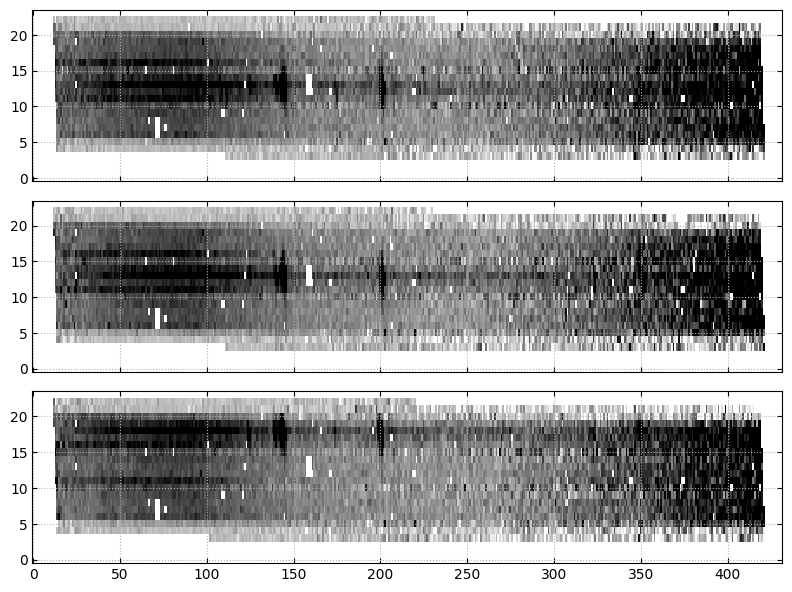

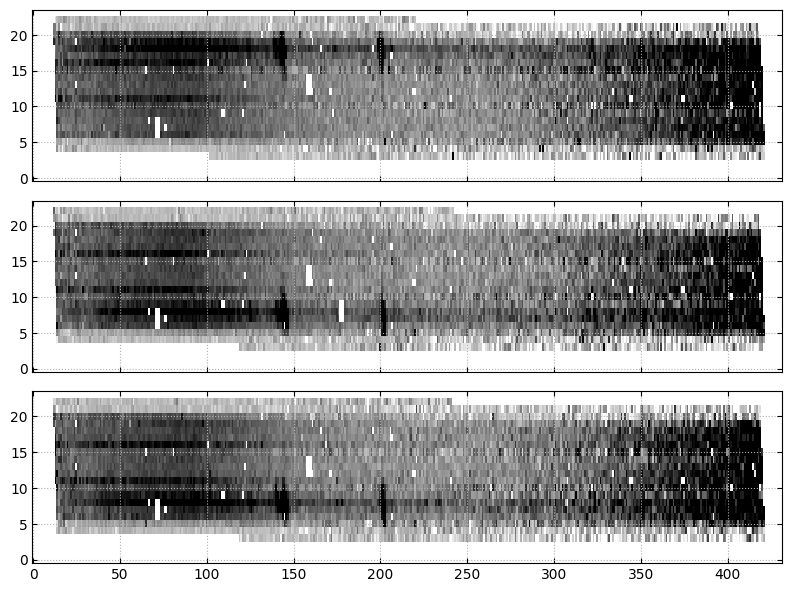

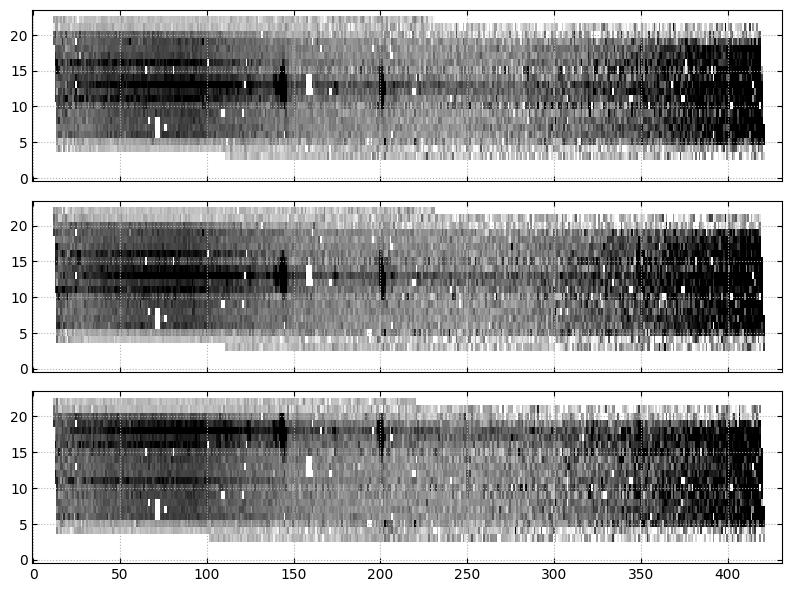

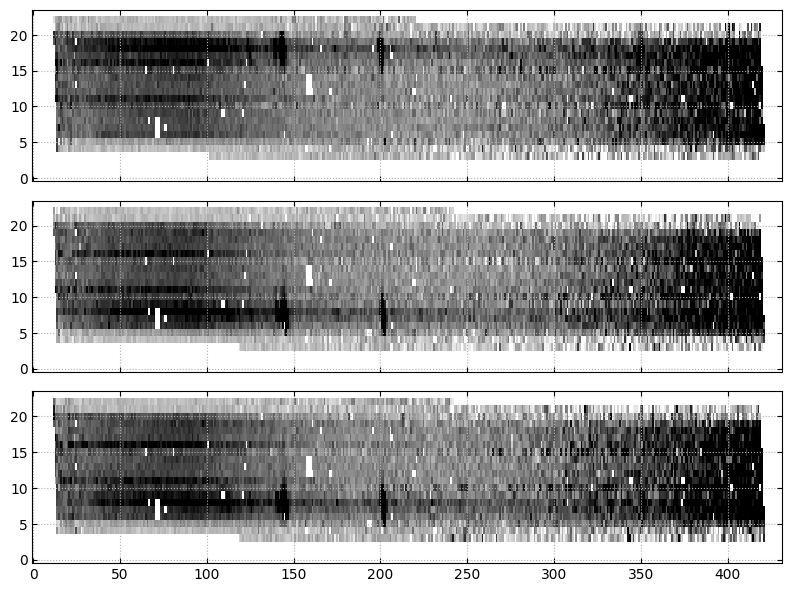

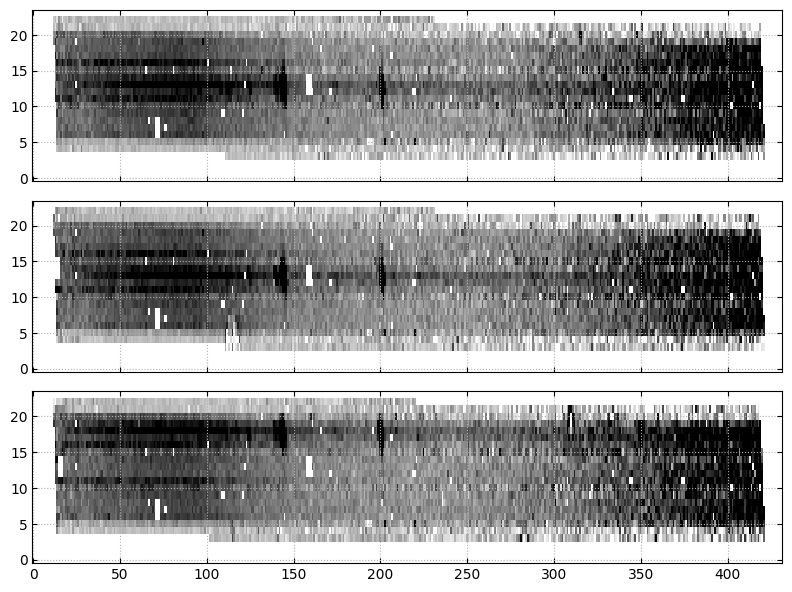

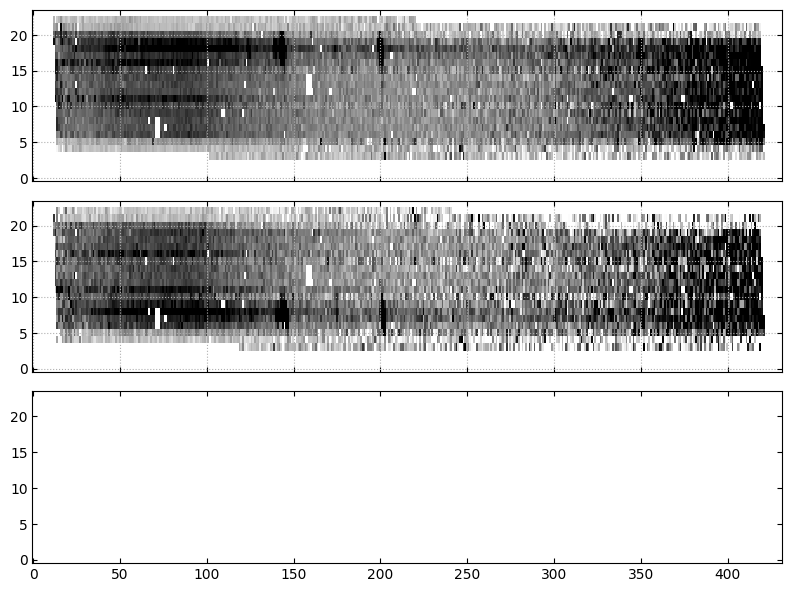

In [64]:
i=0
for i in range(6):
    
    fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True, sharey=True)
    
    for ax, file in zip(axes, phot_files[i*3:i*3+3]):
        dm = jwst.datamodels.open(file)
        ax.imshow(dm.data, vmin=-0.1, vmax=0.3,aspect='auto', cmap='gray_r')
        ax.grid()
        
    fig.tight_layout(pad=1)
    plt.show()

# Exposure combination and spectral extraction

In [66]:
group_kws = dict(
    diffs=True, # For nod differences
    undo_barshadow=2, # For msaexp barshadow correction
    min_bar=0.35, # minimum allowed value for the (inverse) bar shadow correction
    position_key="y_index",
    trace_with_ypos=True, # Include expected y shutter offset in the trace
    trace_from_yoffset=True,
    flag_profile_kwargs=None, # Turn off profile flag
)    

obj = msaexp.slit_combine.SlitGroup(
    phot_files,
    outroot,
    **group_kws,
)

2025-07-05 12:11:36,589 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(



 0 jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  0 flagged hot pixels
 1 jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 2 jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 3 jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 4 jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits (24, 432)  2 flagged hot pixels
 5 jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 6 jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 7 jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 8 jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 9 jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
10 jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels

In [67]:
print(f"""
Number of exposures: {obj.N}
2D array shape: {obj.sh}
Flattened data array: {obj.sci.shape}
""")


Number of exposures: 17
2D array shape: (24, 432)
Flattened data array: (17, 10368)



Show the exposure data again now with the trace.

Also note that the sky is flatter than before with the updated bar shadow correction.

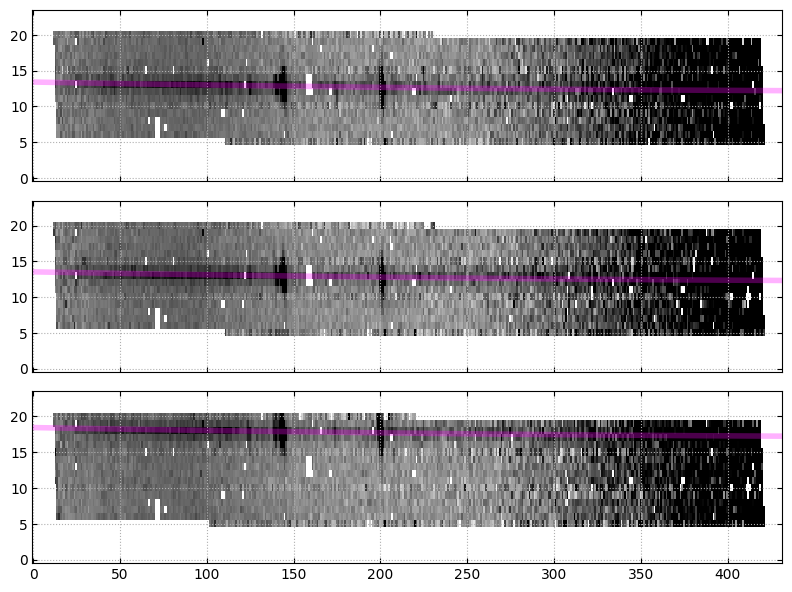

In [68]:
num = 3  # can set to obj.N to display all exposures

fig, axes = plt.subplots(num, 1, figsize=(8,6), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.imshow(obj.sci[i,:].reshape(obj.sh), vmin=-0.1, vmax=0.3, aspect='auto', cmap='gray_r')
    ax.plot(obj.ytr[i,:], color='magenta', alpha=0.3, lw=4)
    ax.grid()
    
fig.tight_layout(pad=1)

## Fit the trace profile

The profile is modeled as a (pixel-integrated) Gaussian with a specified width that is added in quadrature with the tabulated 
PSF width.

In [69]:
fit = obj.fit_all_traces(
    offset_degree=0, # order of the offset polynomial to fit
    force_positive=False,
    x0=[2, 0.], # Initial guess:  gaussian width in pixels x 10, trace offset pixels
    niter=1,
    ref_exp=obj.calc_reference_exposure
)

   fit_all_traces, iter 0
      72  sigma=2.00  [ 0.000]  9822.9
      73  sigma=3.15  [ 0.010]  9158.9
     Exposure group 2   dchi2 =    -664.0

      74  sigma=3.15  [ 0.010]  10289.8
      75  sigma=3.15  [ 0.010]  10289.8
     Exposure group 1   dchi2 =       0.0

      76  sigma=3.15  [ 0.010]  10156.1
      77  sigma=3.15  [ 0.010]  10156.1
     Exposure group 3   dchi2 =       0.0



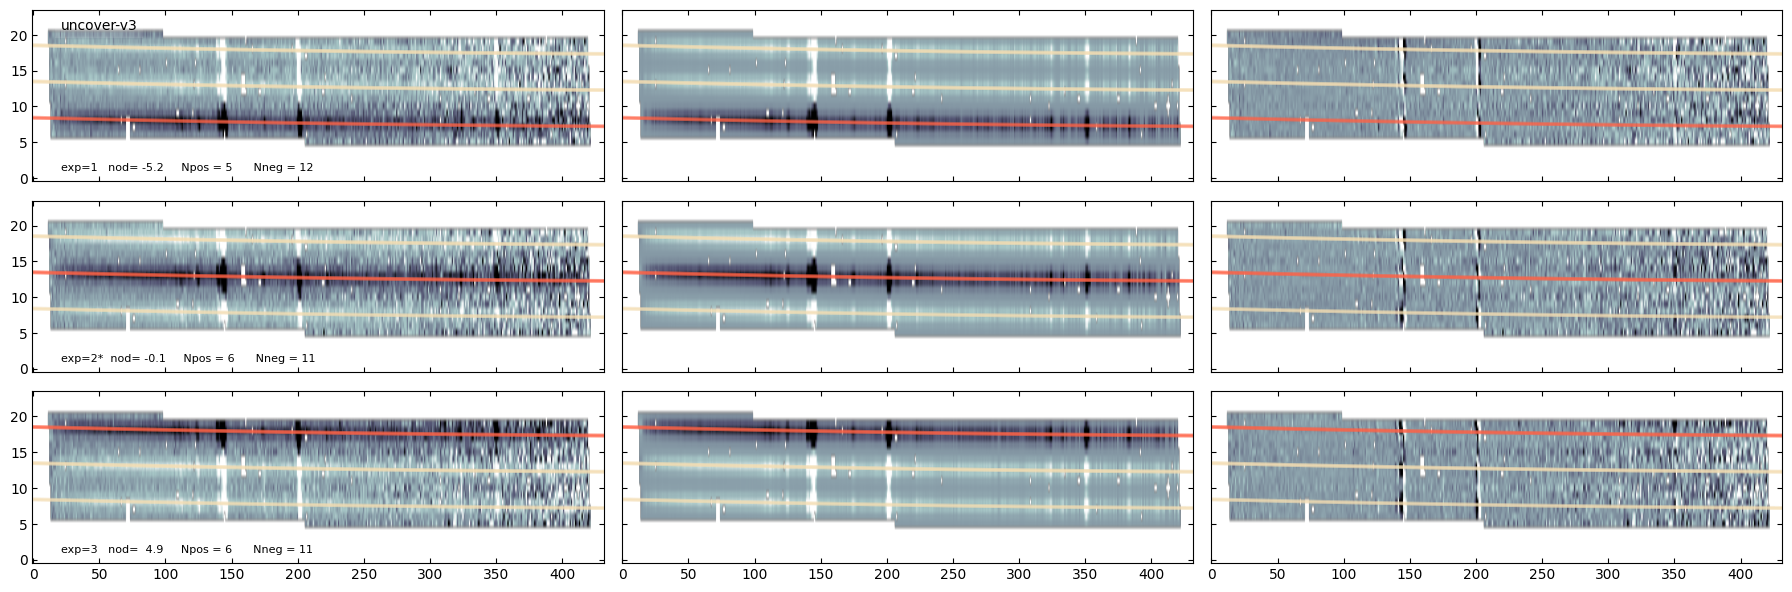

In [70]:
# Show the profile fit
fig2d = obj.plot_2d_differences(fit=fit)

# Resample the spectra to a rectified pixel grid and get optimal 1D extraction

In [71]:
drizzle_kws = dict(
    step=1, # cross dispersion step size
    ny=15, # number of cross dispersion pixels
    with_pathloss=True, # use MSAEXP path loss that accounts for source size
    wave_sample=1.05, # wavelength sampling
    dkws=dict(oversample=16, pixfrac=0.8),
)

hdul = msaexp.slit_combine.combine_grating_group(
    {'prism': {'obj':obj, 'fit': fit}},
     ['prism'],
     drizzle_kws=drizzle_kws
)


msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.31
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 29282.9
msaexp.drizzle.extract_from_hdul: aperture extraction = (15, 1)
msaexp.drizzle.extract_from_hdul:  Output center =    0.00, sigma =   0.31


In [72]:
hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    379   501R x 10C   ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']   
  2  SCI           1 ImageHDU       354   (501, 31)   float64   
  3  WHT           1 ImageHDU       354   (501, 31)   float64   
  4  PROFILE       1 ImageHDU       354   (501, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   ['D', 'D', 'D']   
  6  BACKGROUND    1 ImageHDU       354   (501, 31)   float64   
  7  PIXTAB        1 BinTableHDU     49   100812R x 13C   ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'K', 'D', 'D']   
  8  SLITS         1 BinTableHDU    107   17R x 49C   ['55A', 'K', 'K', 'D', 'D', 'D', 'D', 'D', 'K', '10A', 'D', 'D', 'D', 'D', '3A', 'K', 'K', 'D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'K', '4A', '5A', '5A', '29A', 'K', 'K', 'D', 'K', 'K', 'K', '12A', 'D', 'D', 'D', 'D'

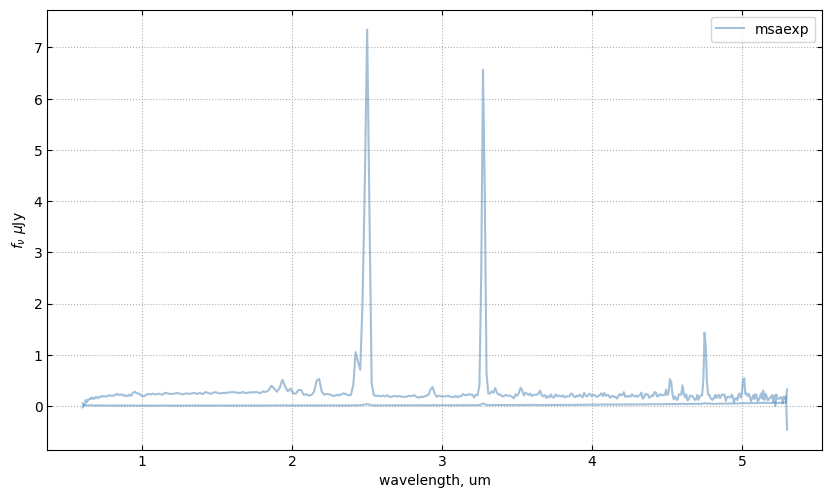

In [73]:
spec = utils.read_catalog(hdul['SPEC1D'])

fig, ax = plt.subplots(1,1,figsize=(10,5))

pl = ax.plot(spec['wave'], spec['flux'], label='msaexp', color='steelblue', alpha=0.5)
ax.plot(spec['wave'], spec['err'], color=pl[0].get_color(), alpha=0.5)

ax.legend()

ax.set_xlabel('wavelength, um')
ax.set_ylabel(r'$f_\nu$ $\mu$Jy')
ax.grid()

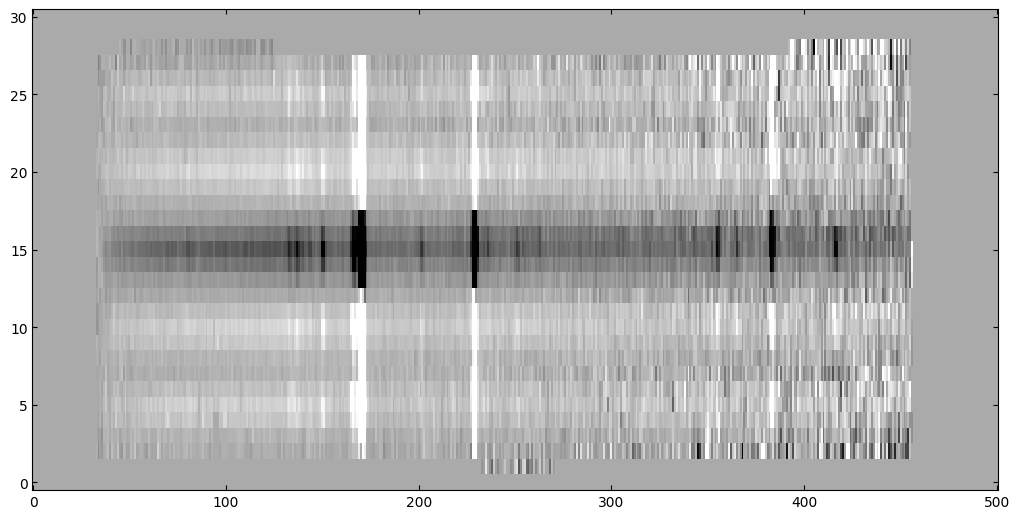

In [74]:
# 2D 
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(hdul['SCI'].data, vmin=-0.1, vmax=0.2, aspect='auto', cmap='gray_r')
fig.tight_layout(pad=0)

## Estimate the sky directly from the spectrum

If the sky is well determined, this can eliminate the need to take the differences of the nodded exposure

 estimate_sky                : 23 outliers > 7  / N=24966 sky pixels 


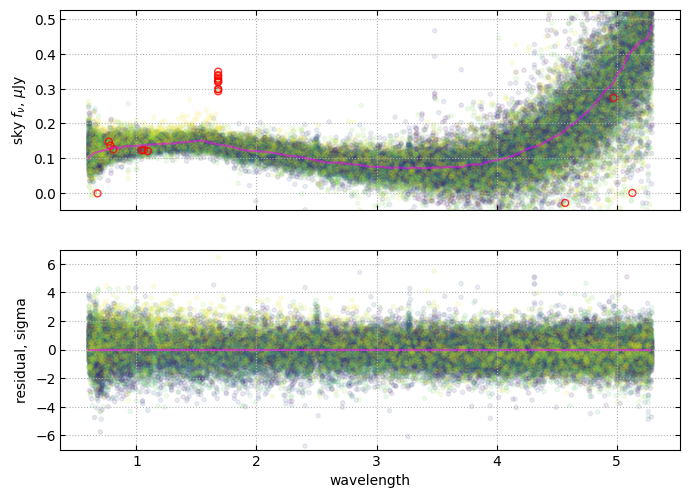

In [75]:
estimate_sky_kwargs = dict(
    mask_yslit=[[-4.5, 4.5]], # mask pixels expected to contain the source
    min_bar=0.95,
    df=81, # number of splines to fit.  Needs to be high to fit the wiggles in the sky spectrum
    high_clip=1.0,
    make_plot=True,
)  

_ = obj.estimate_sky(**estimate_sky_kwargs)

The ``data`` attribute is ``sci - sky2d`` if ``sky2d`` is available

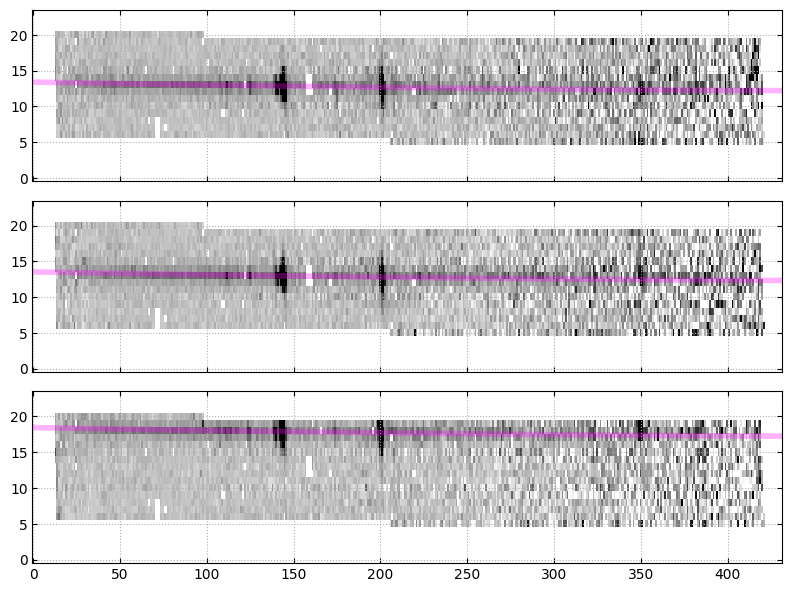

In [76]:
num = 3  # can set to obj.N to display all exposures

fig, axes = plt.subplots(num, 1, figsize=(8,6), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.imshow(obj.data[i,:].reshape(obj.sh), vmin=-0.1, vmax=0.3, aspect='auto', cmap='gray_r')
    ax.plot(obj.ytr[i,:], color='magenta', alpha=0.3, lw=4)
    ax.grid()
    
fig.tight_layout(pad=1)

## Flag outliers based on the cross-dispersion profile

 flag_from_profile           : 102 ( 0.1%) pixels


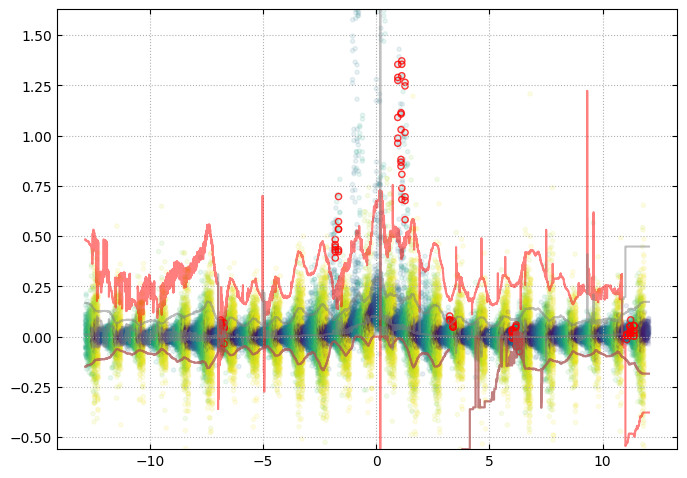

In [77]:
flag_profile_kwargs = dict(require_multiple=True, make_plot=True, grow=2, nfilt=-32)
obj.flag_from_profile(**flag_profile_kwargs)

## Turn off exposure differences and do resample and extraction again

In [78]:
obj.meta["diffs"] = False

In [79]:
drizzle_kws = dict(
    step=1, # cross dispersion step size
    ny=15, # number of cross dispersion pixels
    with_pathloss=True, # use MSAEXP path loss that accounts for source size
    wave_sample=1.05, # wavelength sampling
    dkws=dict(oversample=16, pixfrac=0.8),
)

hdul_nodiff = msaexp.slit_combine.combine_grating_group(
    {'prism': {'obj':obj, 'fit': fit}},
     ['prism'],
     drizzle_kws=drizzle_kws
)


msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.31
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 31116.9
msaexp.drizzle.extract_from_hdul: aperture extraction = (15, 1)
msaexp.drizzle.extract_from_hdul:  Output center =    0.00, sigma =   0.31


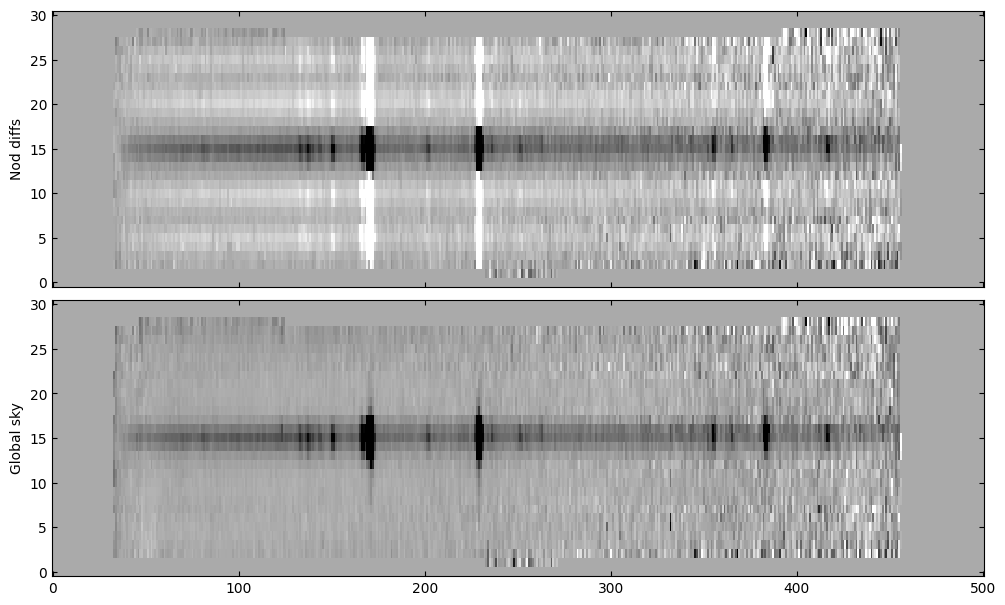

In [80]:
# 2D 
fig, axes = plt.subplots(2,1,figsize=(10,6), sharex=True, sharey=True)
kws = dict(vmin=-0.1, vmax=0.2, aspect='auto', cmap='gray_r')

axes[0].imshow(hdul['SCI'].data, **kws)
axes[0].set_ylabel('Nod diffs')

axes[1].imshow(hdul_nodiff['SCI'].data, **kws)
axes[1].set_ylabel('Global sky')

fig.tight_layout(pad=0.5)

# Combination and extraction wrapped into a single script

# (2025-07-05 04:13:24.284)

slit_combine.extract_spectra(**{'target': '2561_17467', 'root': 'uncover-v3', 'path_to_files': './', 'files': None, 'do_gratings': ['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'], 'join': [0, 3, 5], 'split_uncover': True, 'stuck_threshold': 0.3, 'valid_frac_threshold': 0.1, 'pad_border': 2, 'sort_by_sn': False, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 0, 'degree_kwargs': {}, 'recenter_all': False, 'free_trace_offset': False, 'nod_offset': None, 'initial_sigma': 7, 'fit_type': 1, 'initial_theta': None, 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': None, 'diffs': True, 'undo_pathloss': True, 'undo_barshadow': 2, 'use_first_sky': False, 'drizzle_kws': {'step': 1, 'with_pathloss': True, 'wave_sample': 1.05, 'ny': 13, 'dkws': {'oversample': 16, 'pixfrac': 0.8}}, 'get_xobj': False, 'trace_with_xpos

2025-07-05 12:13:24,601 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(



 0 jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  0 flagged hot pixels
 1 jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 2 jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 3 jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 4 jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits (24, 432)  2 flagged hot pixels
 5 jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 6 jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 7 jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 8 jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 9 jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
10 jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels

2025-07-05 12:13:37,208 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-05 12:13:37,210 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.32
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 27986.0
msaexp.drizzle.extract_from_hdul: aperture extraction = (13, 1)
msaexp.drizzle.extract_from_hdul:  Output center =    0.00, sigma =   0.32
uncover-v3_prism-clear_2561_17467.spec.fits
uncover-v3_prism-clear_2561_17467.pixtab.fits


2025-07-05 12:13:37,401 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-05 12:13:37,402 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



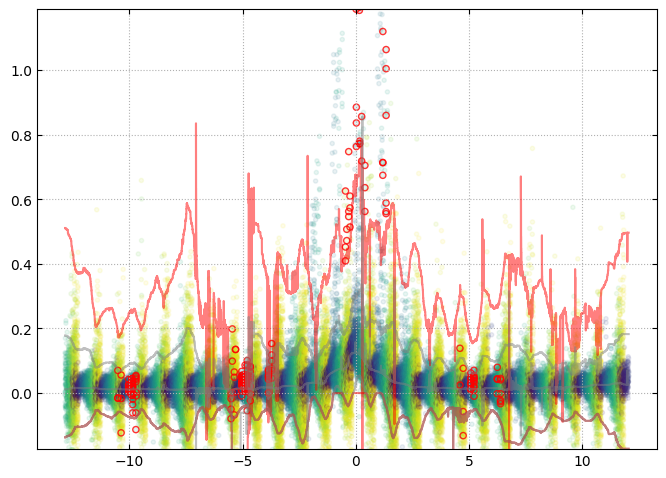

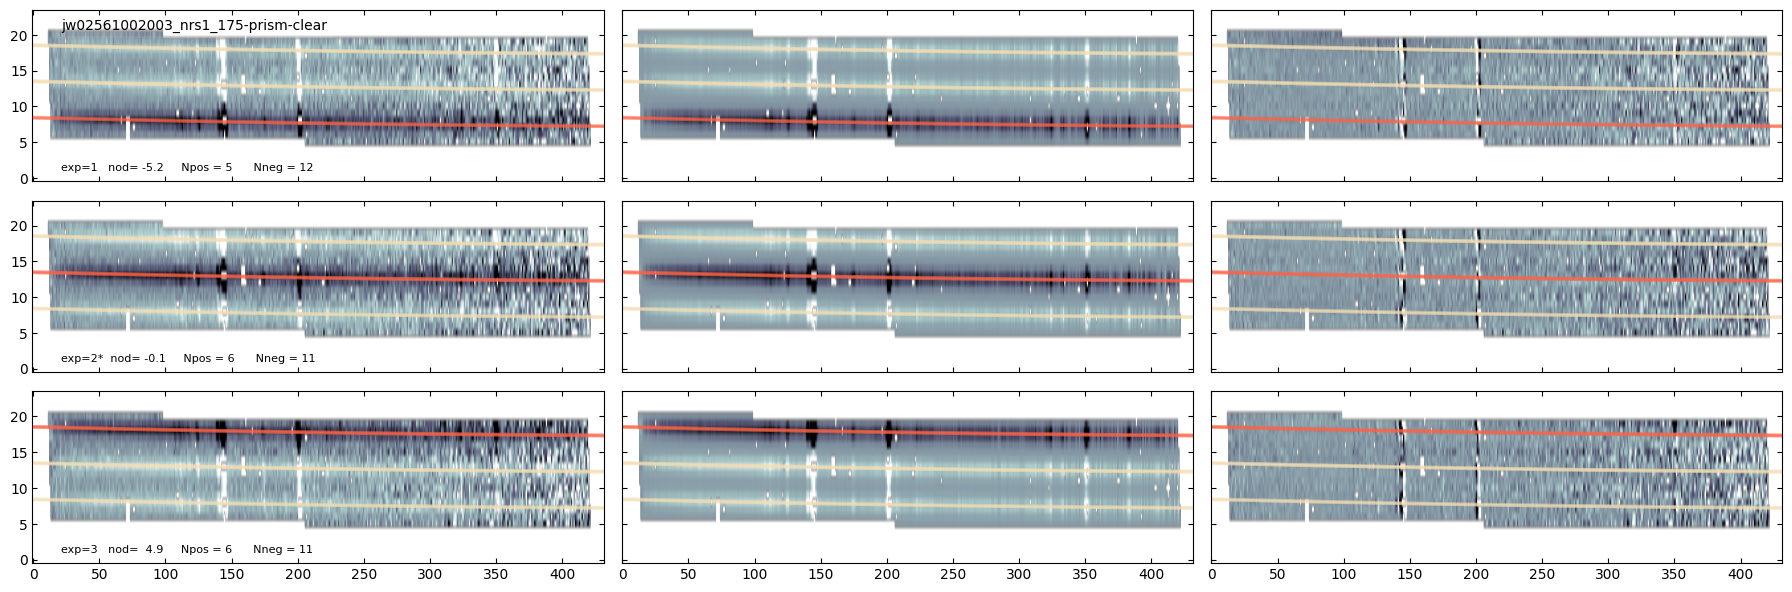

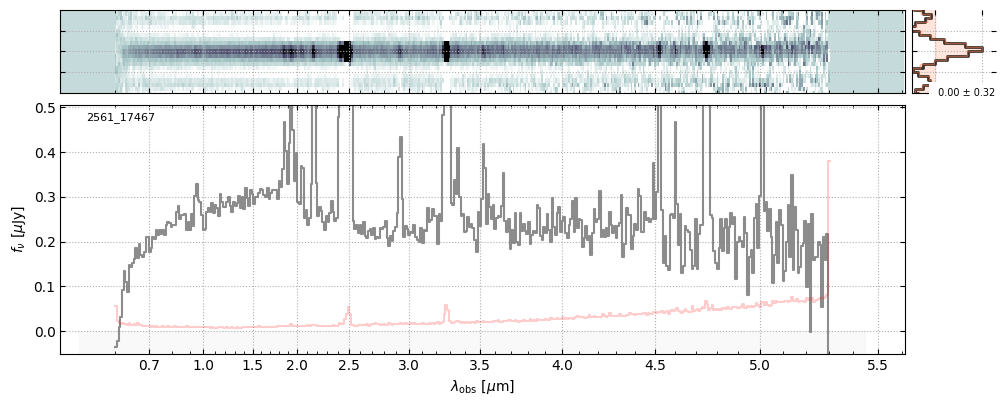

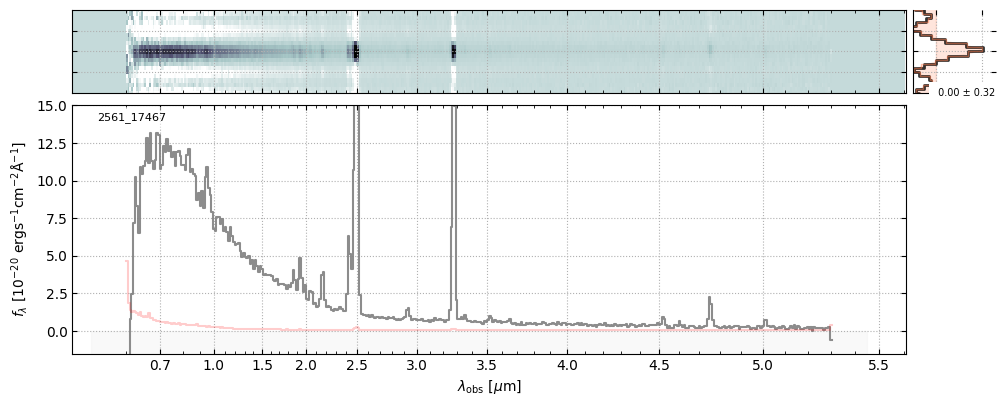

In [83]:
group_kws['diffs'] = True
group_kws['flag_profile_kwargs'] = flag_profile_kwargs

target=f'{prog}_{source_ids[1]}'

_ = msaexp.slit_combine.extract_spectra(
    target=target,
    root=outroot,
    **group_kws,
)

# (2025-07-05 04:13:50.988)

slit_combine.extract_spectra(**{'target': '2561_17467', 'root': 'uncover-v3', 'path_to_files': './', 'files': None, 'do_gratings': ['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'], 'join': [0, 3, 5], 'split_uncover': True, 'stuck_threshold': 0.3, 'valid_frac_threshold': 0.1, 'pad_border': 2, 'sort_by_sn': False, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 0, 'degree_kwargs': {}, 'recenter_all': False, 'free_trace_offset': False, 'nod_offset': None, 'initial_sigma': 7, 'fit_type': 1, 'initial_theta': None, 'fix_params': False, 'input_fix_sigma': None, 'fit_params_kwargs': None, 'diffs': False, 'undo_pathloss': True, 'undo_barshadow': 2, 'use_first_sky': False, 'drizzle_kws': {'step': 1, 'with_pathloss': True, 'wave_sample': 1.05, 'ny': 13, 'dkws': {'oversample': 16, 'pixfrac': 0.8}}, 'get_xobj': False, 'trace_with_xpo

2025-07-05 12:13:51,306 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(



 0 jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  0 flagged hot pixels
 1 jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 2 jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 3 jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 4 jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits (24, 432)  2 flagged hot pixels
 5 jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 6 jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 7 jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 8 jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
 9 jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels
10 jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits (24, 432)  1 flagged hot pixels

2025-07-05 12:14:01,044 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-05 12:14:01,045 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



msaexp.drizzle.extract_from_hdul: Initial center =    0.00, sigma =   0.34
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 32649.5
msaexp.drizzle.extract_from_hdul: aperture extraction = (13, 1)
msaexp.drizzle.extract_from_hdul:  Output center =    0.00, sigma =   0.34
uncover-v3_prism-clear_2561_17467.spec.fits
uncover-v3_prism-clear_2561_17467.pixtab.fits


2025-07-05 12:14:01,227 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-07-05 12:14:01,227 - stpipe - WARNING - /Users/xwang/anaconda3/envs/grizli-jwst/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



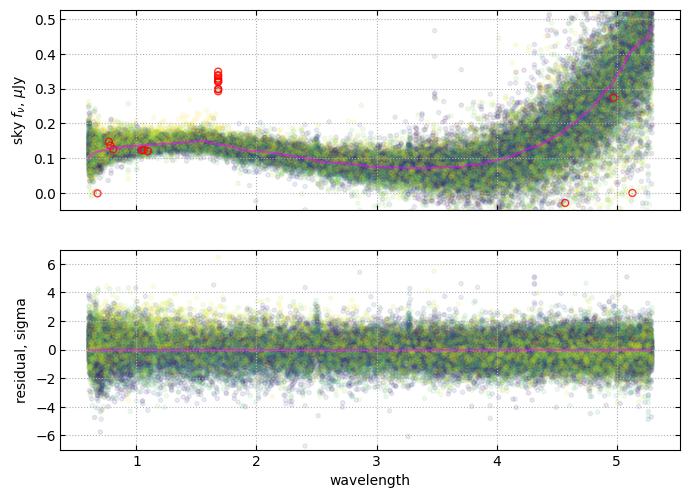

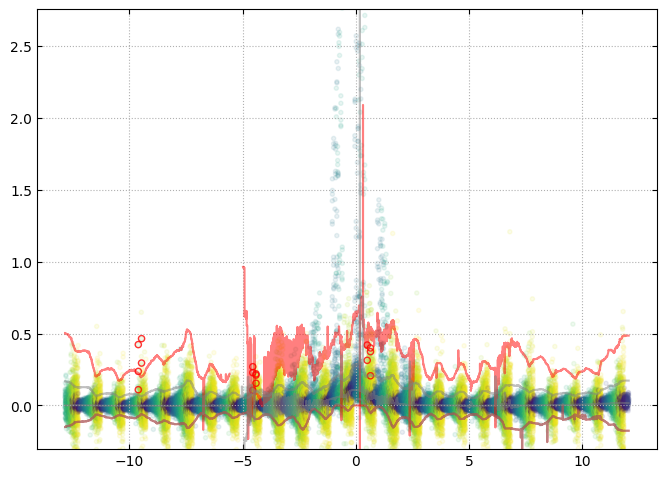

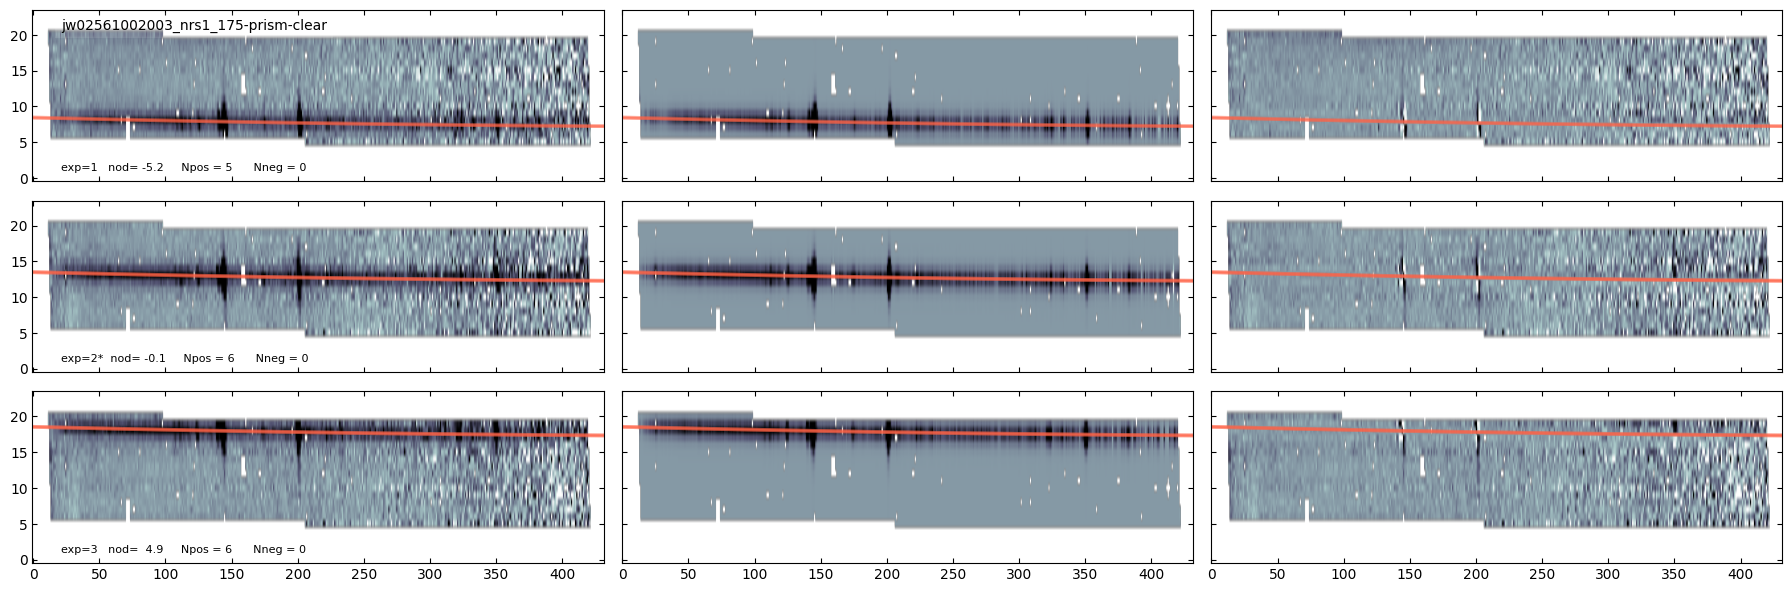

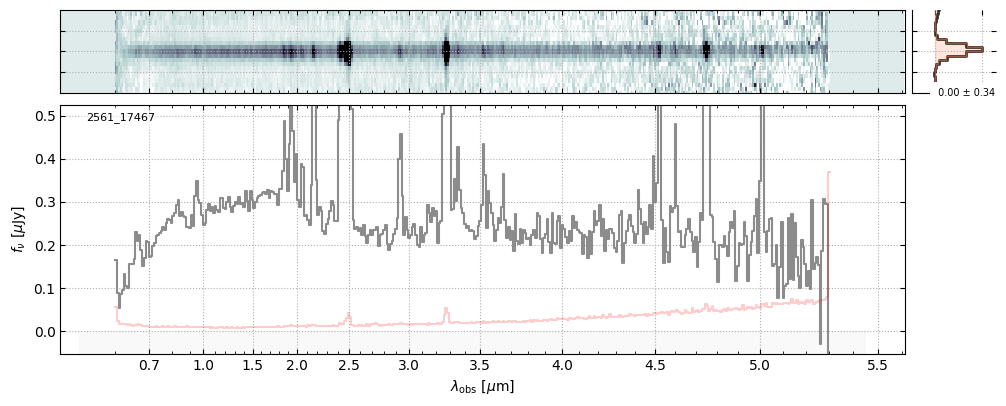

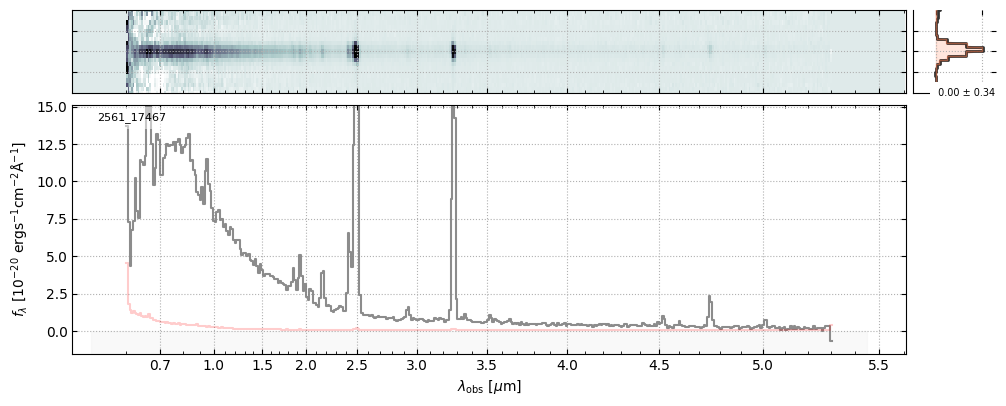

In [84]:
# With sky estimation
group_kws['diffs'] = False

_ = msaexp.slit_combine.extract_spectra(
    target=target,
    root=outroot,
    estimate_sky_kwargs=estimate_sky_kwargs,
    **group_kws,
)

In [85]:
! ls *{target}.*

jw02561002003_03101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_03101_00007_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00005_nrs1_phot.175.2561_17467.fits
jw02561002003_05101_00006_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00001_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00002_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00003_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00004_nrs1_phot.175.2561_17467.fits
jw02561002003_07101_00005_nrs1_phot.175.2561_17467.fits
uncover-v3_2561_17467.extract.log
uncover-v3_256

# Fitting and analysis

Now go to the ``s2_specAnalysis.ipynb`` notebook for a demo on fitting the spectra for redshift, lines, etc.